In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
ind_df= pd.read_csv("../data/processed/processed_ind_data.csv")
team_df = pd.read_csv("../data/processed/processed_team_data.csv")

In [ ]:
# Separate individual and team data

team_df = scale_frames[0]

# Drop keepers (sorry keepers)
ind_df = ind_df[ind_df['Pos'] != 'GK'].reset_index(drop=True)

#### Drop players who have played below certain threshold
# Find number of games in each league
games_played = team_df[['League', '90s']].drop_duplicates().reset_index(drop=True) # Get only leagues and games played
games_tuple = list(games_played.itertuples(index=False ,name=None)) # Tuple for nicer iteration
games_played['90s'] = pd.to_numeric(team_df['90s']) # Numbers for mathing things
ind_df['90s'] = pd.to_numeric(ind_df['90s'])

# Definition to divide player's 90s by total team games played
def check_league(x, games_played):
    for league, games in games_tuple:
        if league in x['League']:
            return x['90s']/games
    return None
ind_df['90s'] = ind_df.apply(lambda x: check_league(x, games_played), axis = 1)

# Then, drop players who've played less than minimum in that league
## Initially set to 20% of possible minutes
ind_df = ind_df[ind_df['90s'] > 0.20]

# There are about 5 players who don't have stats here, so just remove them.
ind_df = ind_df[ind_df['Short%'].notna()]

# Give negative value for certain stats to show they did not even attempt that action
# Will differentiate them in the clustering from players where the stat is zero.
ind_df.replace([np.nan], -0.02, inplace=True)
ind_df.replace([np.inf], 100, inplace=True)

# Things/ways to normalize:
# Normalize by team (see if they do the thing a lot within their team)
norm_stats = [ '+/-', 'xG+/-', 'onxG', 'onxGA', 'onG-xG', 'onGA-xGA', 'G-xG+/-', 'TotPassAtt', 'TotalTouches']
for stat in norm_stats:
    ind_df[stat] = ind_df[stat].div(ind_df['Squad'].map(team_df.set_index('Squad')[stat]))

# Normalize by possession
## Defensive stats normalized by other teams possession (1-team possession%), 
norm_stats = [ 'Tkl', 'Blocks', 'Int', 'Fls', 'PKcon']
for stat in norm_stats:
    ind_df[stat] = ind_df[stat].div(ind_df['Squad'].map(team_df.set_index('Squad')["OppPoss"]))

# Normalize these by team's own possession
norm_stats = ['AttDribbles', 'SCA90',  'onG', 'onGA', 'Fld', 'PKwon']
for stat in norm_stats:
    ind_df[stat] = ind_df[stat].div(ind_df['Squad'].map(team_df.set_index('Squad')["Poss"]))



In [ ]:
ind_df.head()

,Player,League,Nation,Pos,Squad,Born,90s,Gls/90,SoT%,Sh/90,...,G-xG+/-,CrdY,Fls,Fld,TimesOffside,PKwon,PKcon,Recov,DuelWin%,AerialDuels
1,Marcos Acuña,La-Liga,ARG,DF,Sevilla,1991.0,0.660526,0.039841,0.313,0.64,...,0.413408,10,3.728927,3.219445,0.000000,0.0,0.098130,6.892430,0.407,2.151394
2,Martin Agirregabiria,La-Liga,ESP,DF,Alavés,1996.0,0.473684,0.000000,0.000,0.22,...,0.613208,4,2.298851,2.910053,0.055556,0.0,0.095785,4.388889,0.534,3.222222
5,Joseph Aidoo,La-Liga,GHA,DF,Celta Vigo,1995.0,0.771053,0.000000,0.167,0.20,...,1.392857,1,0.761824,1.112925,0.034130,0.0,0.000000,5.597270,0.569,3.720137
6,Carlos Akapo,La-Liga,EQG,DF,Cádiz,1993.0,0.539474,0.000000,0.100,0.49,...,1.229508,4,1.911331,2.952814,0.097561,0.0,0.083101,5.463415,0.536,3.365854
9,David Alaba,La-Liga,AUT,DF,Real Madrid,1992.0,0.773684,0.068027,0.333,0.72,...,0.415301,2,1.357151,0.340704,0.068027,0.0,0.000000,4.795918,0.389,1.224490


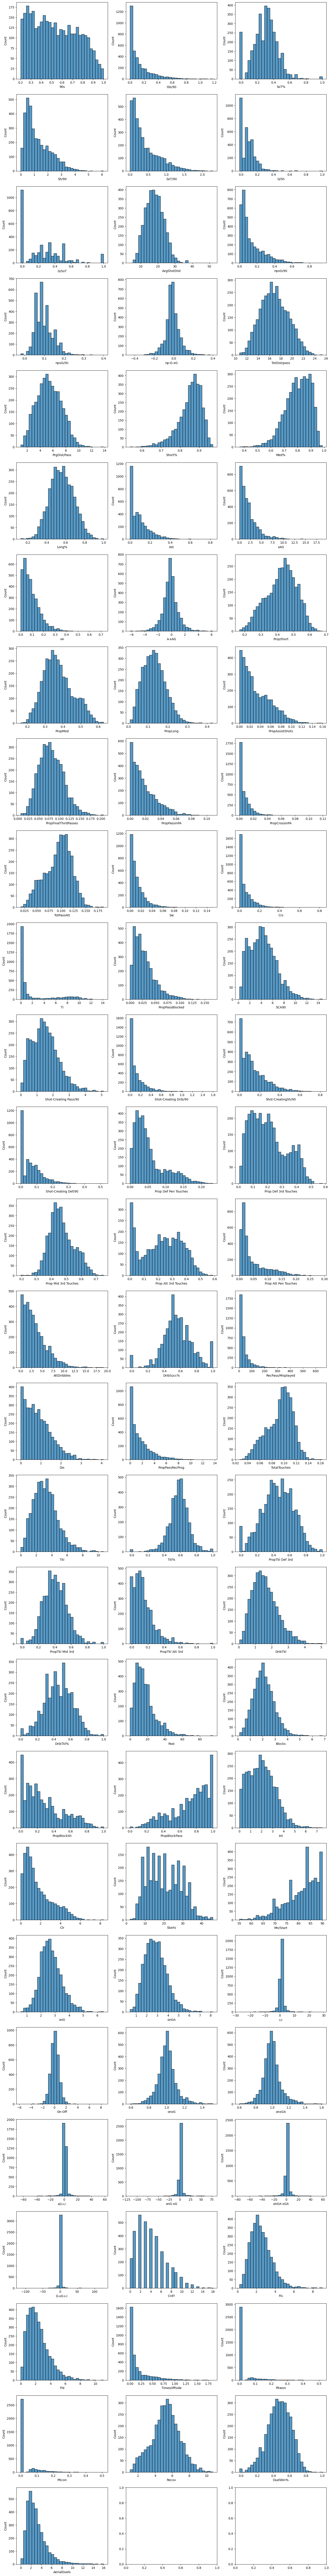

In [ ]:
# Creating subplot axes
col_names = ind_df.columns[6:]
plot_ind_df = ind_df.iloc[:,6:]
fig, axes = plt.subplots(28, 3, figsize=[18,150])

# Iterating through axes and names
for name, ax in zip(col_names, axes.flatten()):
    sns.histplot(x= name, data=plot_ind_df, bins = 30, ax=ax)
fig.savefig("../reports/normalized_data.png")

In [ ]:
# More specific name for this
ind_df.rename(columns={'Prog': "PropPassRecProg"}, inplace=True)

In [ ]:
# Before analyzing, going to delete columns that won't be used in clustering (namely, goal-creation and goal/assist data)
copy_ind_df = ind_df.copy()
copy_ind_df.drop(columns = ['Gls/90', 'np:G-xG', 'Ast','xA', 'DribSucc%', 'onG', 'onGA', '+/-',
           'On-Off', 'onxG', 'onxGA', 'xG+/-', 'onG-xG', 'onGA-xGA', 'G-xG+/-', 'Starts', 'Mn/Start', 'A-xAG', 'Shot-Creating Def/90', 'Tkl%'  ], inplace=True)

/tmp/ipykernel_16310/1242139497.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = np.abs(copy_ind_df.corr())


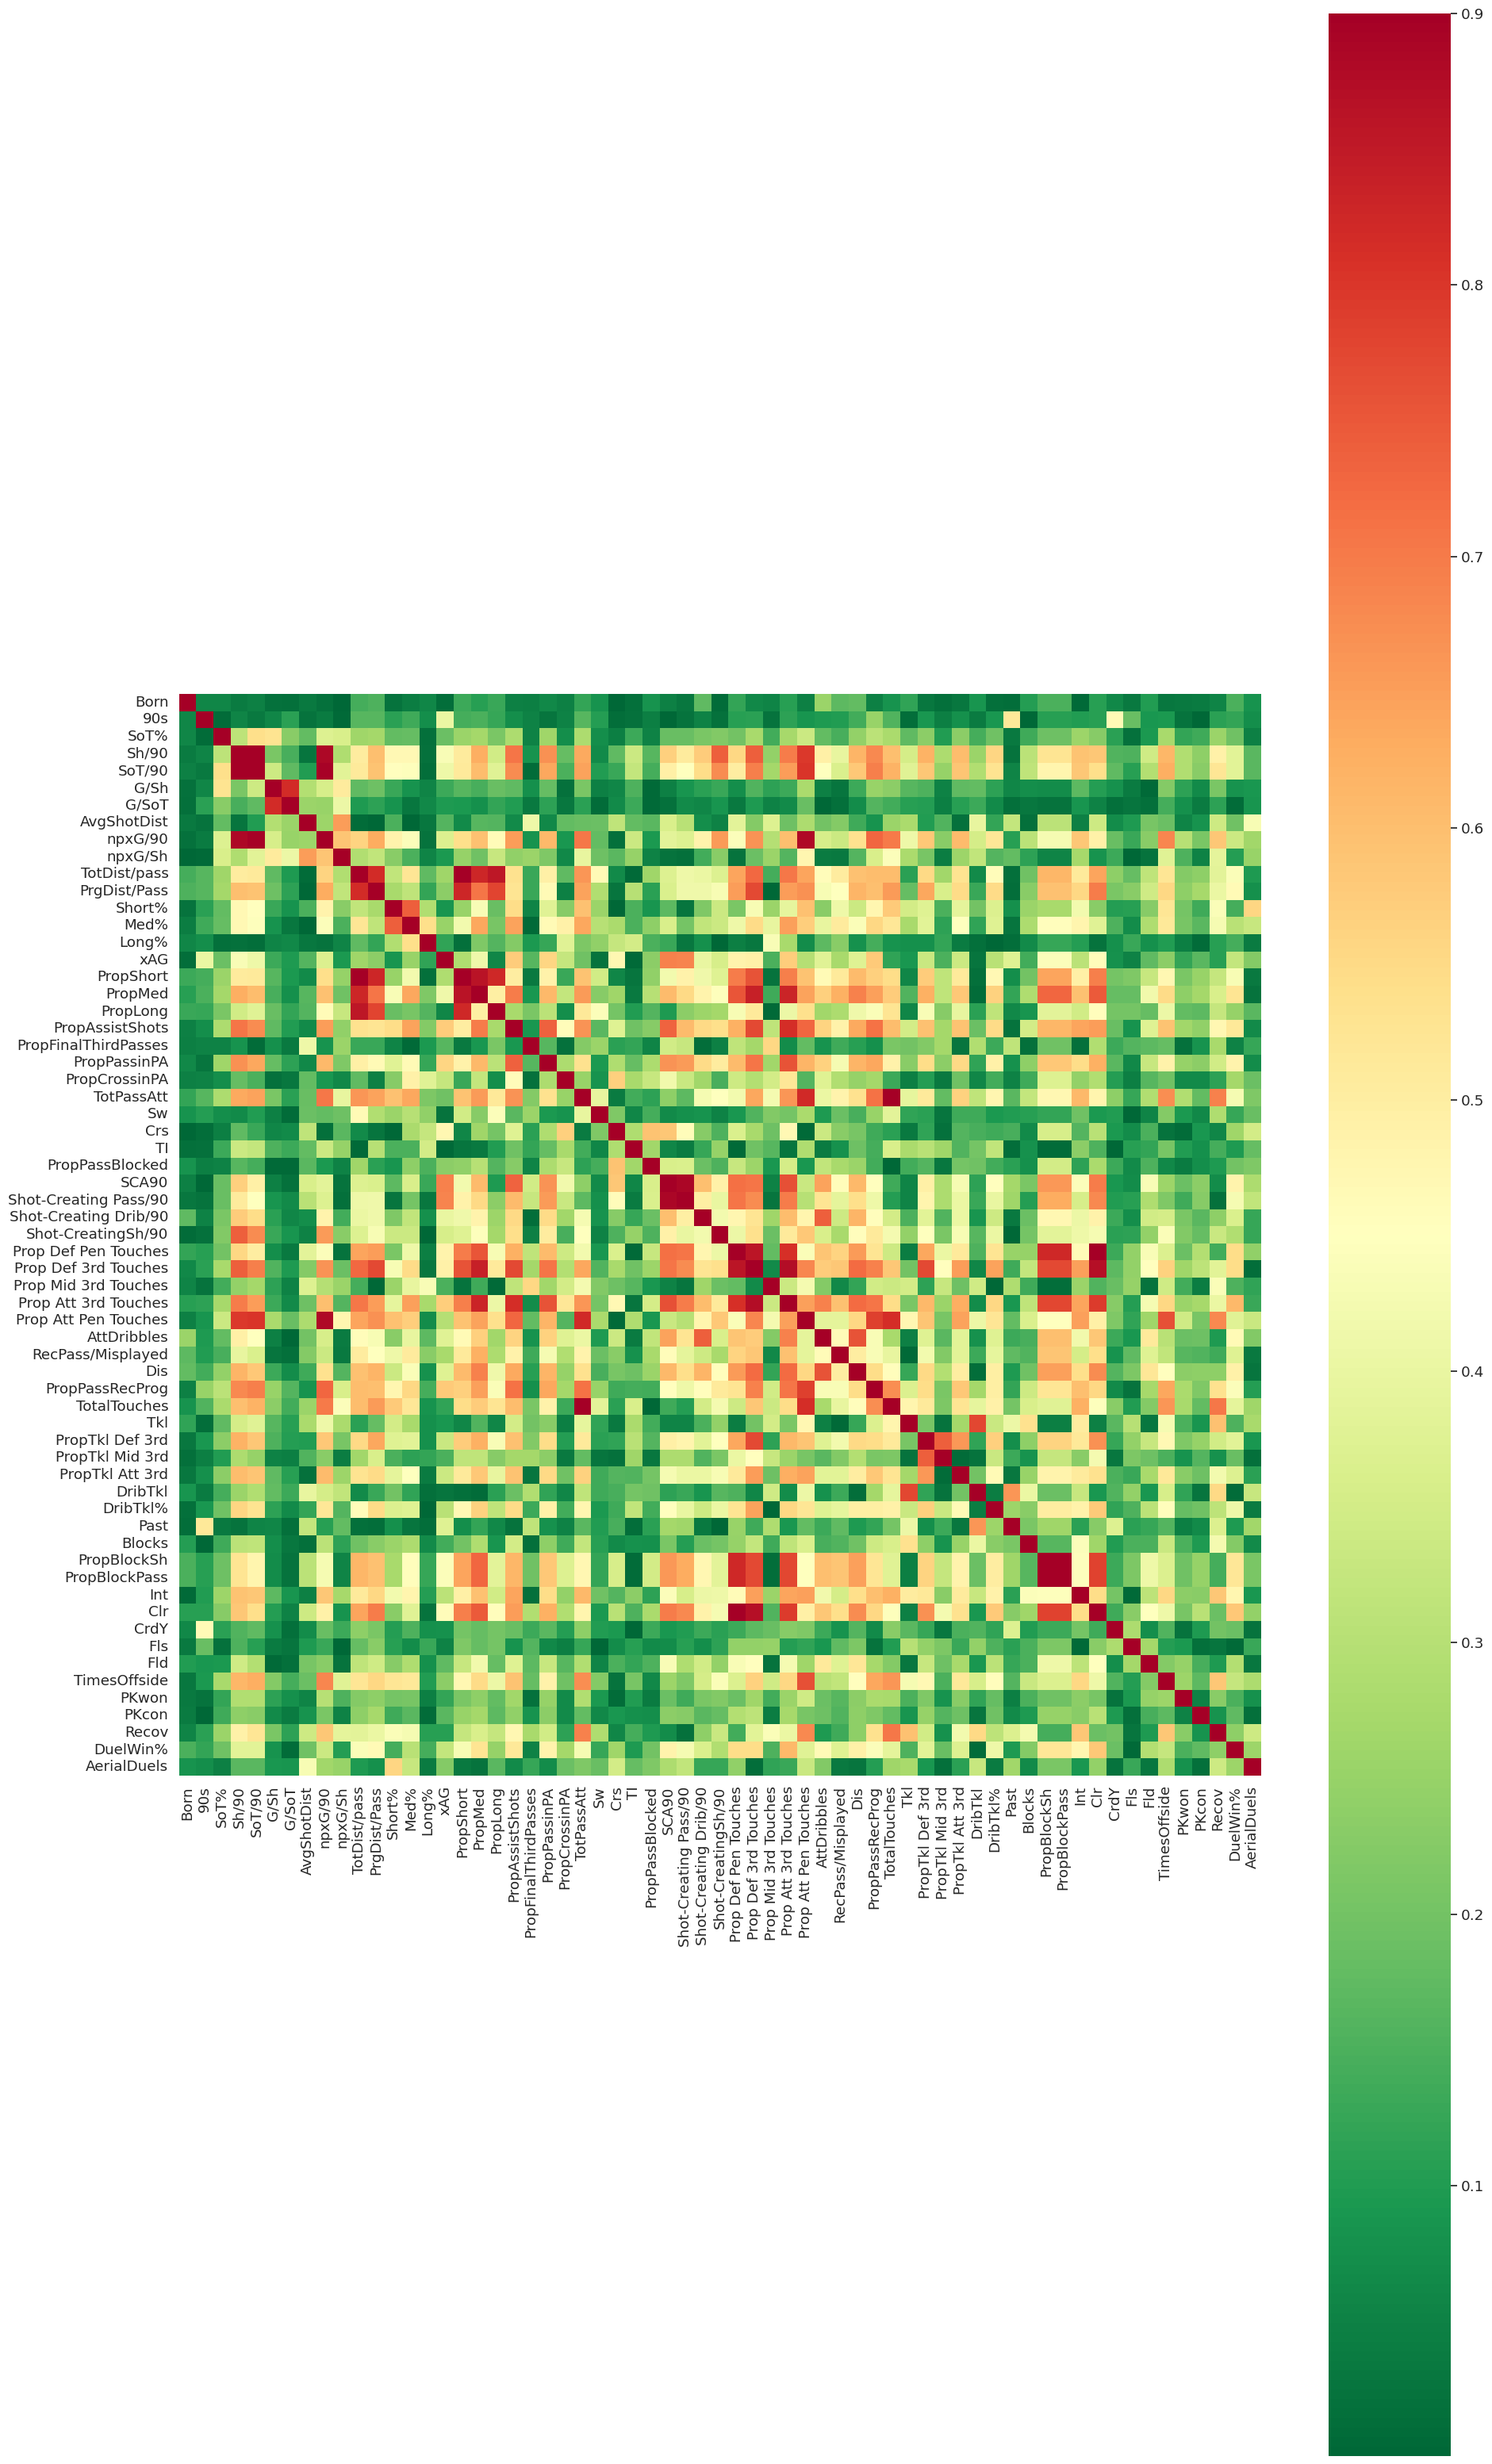

In [ ]:
# Check for correlations too, I guess?
# Do them all (not super readable)
corrmat = np.abs(copy_ind_df.corr())
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(22,40))         # Sample figsize in inches
sns.heatmap(corrmat, vmax=0.9, square=True, cmap="RdYlGn_r")
plt.show()

/tmp/ipykernel_16310/2207941356.py:22: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = np.abs(ind_df.corr())


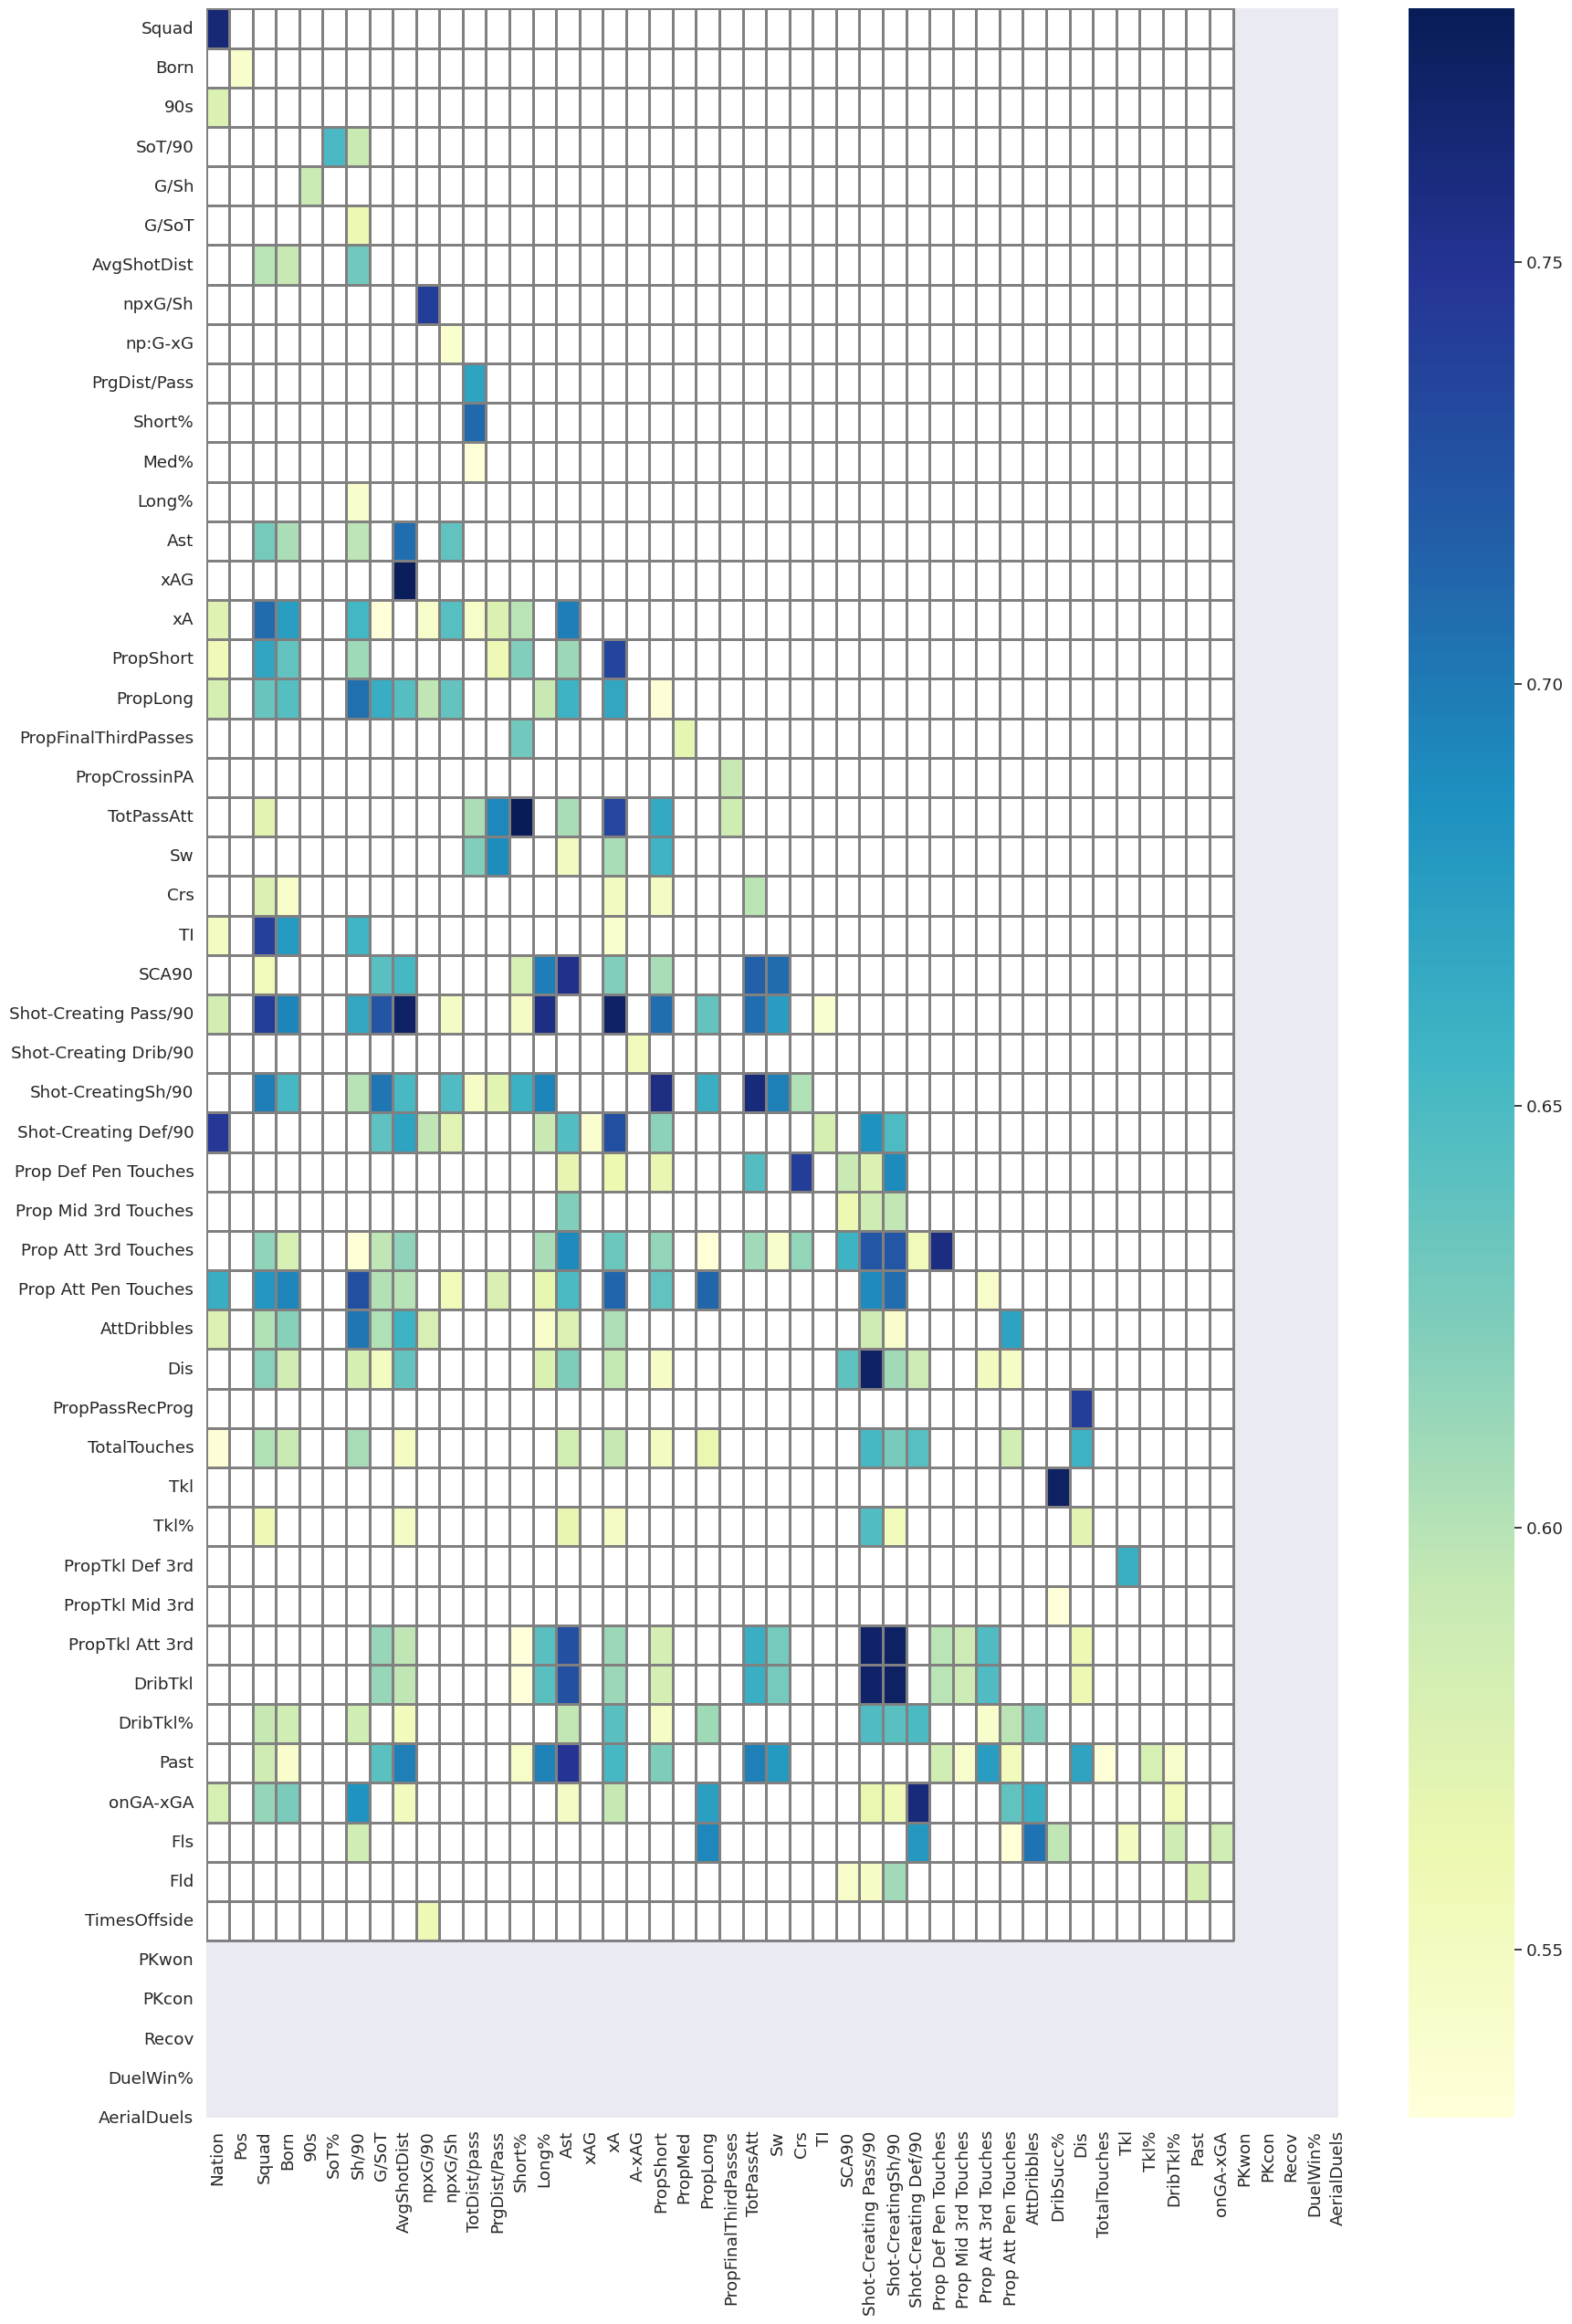

In [ ]:
# Only check for correlations that are above certain threshold
from copy import copy
corr_thresh = 0.53
corr_max = 0.78

# Get names of things
labels = ind_df.columns

#plotting starts here
sns.set(font_scale=1.2)
#two axis objects just for comparison purposes
fig, ax = plt.subplots(figsize=(20,30))

#define the colormap with clipping values
my_cmap = copy(plt.cm.YlGnBu)
my_cmap.set_over("white")
my_cmap.set_under("white")

#remove empty rows/columns
# use only lower triangle

corrmat = np.abs(ind_df.corr())
corr = np.tril(corrmat)

#delete columns where all elements do not fulfill the conditions
ind_x,  = np.where(np.all(np.logical_or(corr<corr_thresh, corr>corr_max), axis=0))
corr = np.delete(corr, ind_x, 1)
#update x labels
map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]
    
#now the same for rows 
ind_y, = np.where(np.all(np.logical_or(corr<corr_thresh, corr>corr_max), axis=1))
corr = np.delete(corr, ind_y, 0)
#update y labels
map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]

#plot heatmap
g2 = sns.heatmap(corr,
    xticklabels=map_labels_x,
    yticklabels=map_labels_y,
    vmin=corr_thresh,
    vmax=corr_max,
    cmap=my_cmap,
    linewidths=1.0,
    linecolor="grey", ax=ax)

# g2.set_title("Reduced heatmap")

plt.show()




General takeaways:

- Things that don't really correlate with anything: x-xA, Tkl% , PropRight/PropLeft (so footedness doesn't matter), SCDef, PropProgDist, 
- G-xG stats (G-xG, onG-onxG, onGA-onxGA), when normalized by team, begin to not matter very much 


Normalizing to do:
- Standard Scaler (rescale values so mean=0, variance=1)
    - 'TotDist/pass', 'PrgDist/Pass', 'Att', 'TotDist/Carry', 'Targ', 'Def 3rd Touch', 'Tkl', 'DribTkl', 
       'Press', 'Blocks', 'Int', 'Clr', 'Fls', 'Fld', 'Recov', 'AerialDuels'
- Min-Max Scaler (scale to be between 0-1)
         - 'TI'
- Robust Scaler (for outliers)
         - Dist


In [ ]:
# Remove the stats that we've seen from EDA may not be relevant (low correlations, accounted for by other stats...)
ind_df.drop(columns=["SoT%", "SoT/90", 'G/Sh', 'G/SoT', 'Tkl%', 'Shot-Creating Def/90', 'SCA90',  'CrdY', 'PKwon', 'PKcon'], inplace=True)

In [ ]:
team_df.to_csv(f'../data/processed/normed_team_data.csv') #Assumes location of 'data' folder
ind_df.to_csv(f'../data/processed/normed_individual_data.csv') #Assumes location of 'data' folder